## Импортируем нужные для анализа данных библиотеки

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
# Прочитаем датасет из csv файла и посмотрим на его размер
dataset = pd.read_csv('dataset.csv')
dataset.shape

(7043, 21)

## Смотрим на данные глазами и поправляем их при необходимости

Что понятно:
1) Каждая строчка - клиент с какими-то признаками (20 столбцов)
2) Целевая переменная - churn (ушел клиент или нет)

In [3]:
dataset.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
#Нужно заменить пустые строки в столбце TotalCharges на nan
dataset['TotalCharges'] = dataset["TotalCharges"].replace(" ",np.nan)
#Дропаем строки с пропущенными значениями TotalCharges (их всего несколько штук - нестрашно)
dataset = dataset[dataset["TotalCharges"].notnull()]
dataset = dataset.reset_index()[dataset.columns]

#переведем вещественные и целые числа к нужному типу
dataset["TotalCharges"] = dataset["TotalCharges"].astype(float)
dataset["MonthlyCharges"] = dataset["MonthlyCharges"].astype(float)
dataset["tenure"] = dataset["tenure"].astype(int)

#а здесь наоборот переводим в категориальную переменную (да/нет)
dataset["SeniorCitizen"] = dataset["SeniorCitizen"].replace({1:"Yes",0:"No"})

#разделяем колонки на два типа (категориальные и вещественные). Зависимую переменную преобразуем потом
numeric_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
categorical_cols = list(set(dataset.columns.values.tolist()) - set(numeric_cols) - set(['Churn','customerID']))
print(categorical_cols)

['PhoneService', 'OnlineBackup', 'Contract', 'StreamingMovies', 'DeviceProtection', 'gender', 'SeniorCitizen', 'StreamingTV', 'OnlineSecurity', 'PaperlessBilling', 'Dependents', 'Partner', 'TechSupport', 'MultipleLines', 'InternetService', 'PaymentMethod']


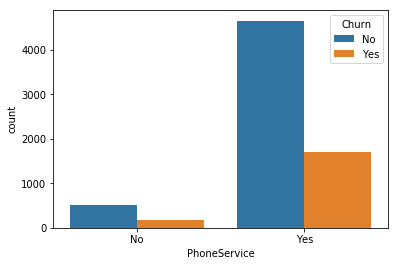

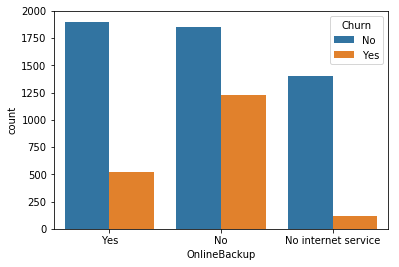

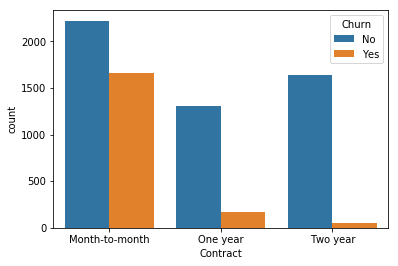

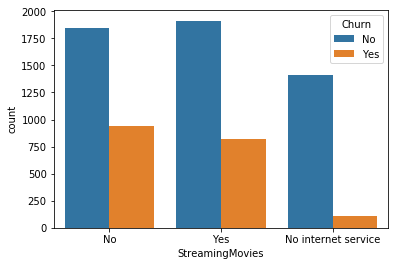

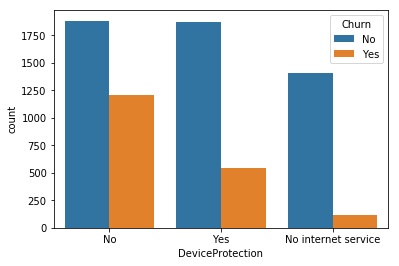

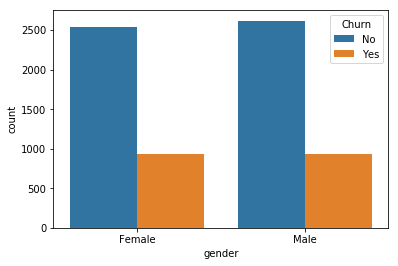

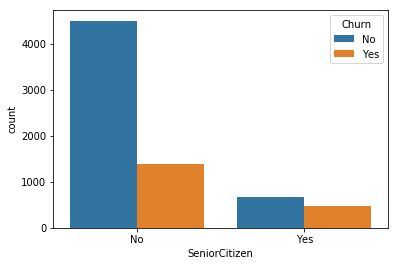

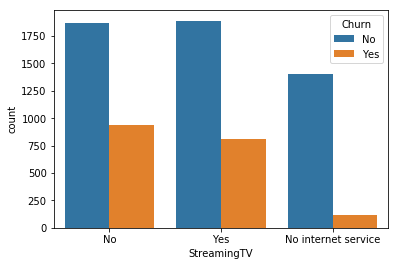

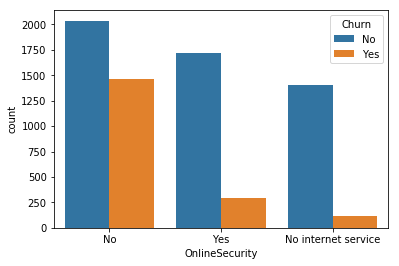

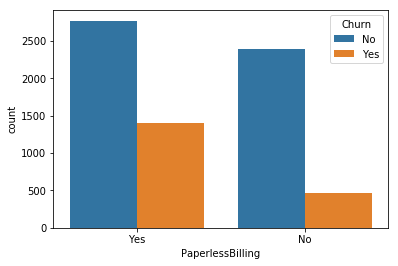

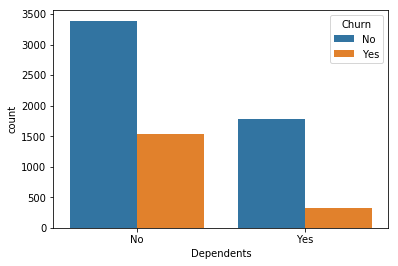

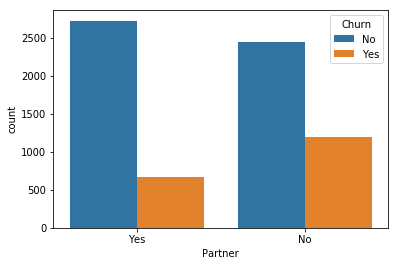

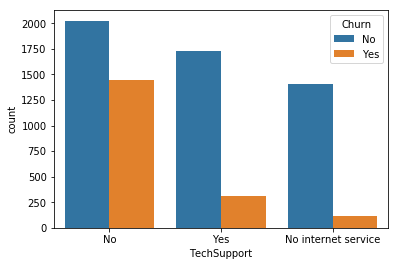

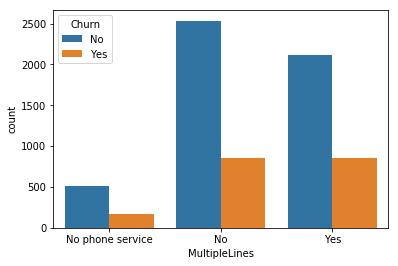

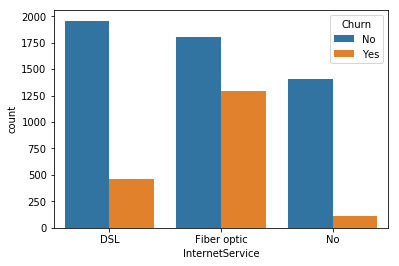

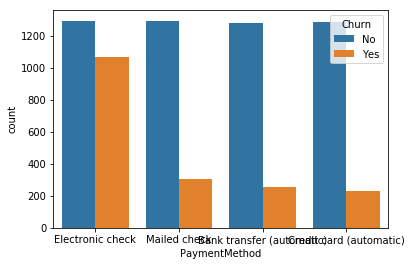

In [5]:
# красиво кучу графиков нарисовать не смог, сорри ¯\_(ツ)_/¯
# Графики подсказывают распределение отточников по признакам
# Например сразу видно, что среди тех, у кого нет Online Backup процент отточников выше
for var in categorical_cols:
    ax = sns.countplot(x=var,hue="Churn", data=dataset)
    i =+1
    plt.show()

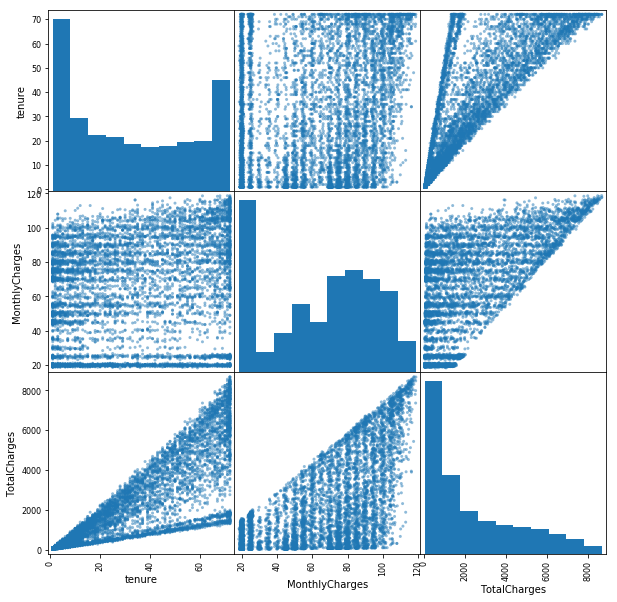

In [6]:
# посмотрим глазами на вещественные признаки. Видно что tenure*monthly_charges дают TotalCharges. 
pd.plotting.scatter_matrix(dataset, alpha=0.5, figsize=(10, 10))
plt.show()

In [7]:
# Разделим датасет на целевую переменную и зависимые
X = dataset.drop('Churn', 1)
Y = dataset['Churn']

# X дополнительно разделим на категориальные и вещественные переменные
X_number = X[numeric_cols]
X_categ = X[categorical_cols]
#на всякий случай все категориальные приведем к строке (вроде они и так строки)
X_categ = X_categ.astype(str)

# Энкодер категориальных переменных

In [8]:
from sklearn.feature_extraction import DictVectorizer as DV

encoder = DV(sparse = False)
# Преобразуем категориальные переменные в множество бинарных признаков с помощью one hot encoder
encoder.fit(X_categ.T.to_dict().values())
X_categ_encoded = encoder.transform(X_categ.T.to_dict().values())
# Преобразуем зависимую переменную в множество бинарных признаков с помощью one hot encoder
Y_new = list(map((lambda x: 1 if x == 'Yes' else 0),Y))
Y_encoded = np.asarray(Y_new)

## Скейлер вещественных переменных

In [9]:
from sklearn.preprocessing import StandardScaler

#нормализуем вещественные признаки (приводим к виду от 0 до 1)
scaler = StandardScaler()
scaler.fit(X_number)
X_number_scaled = scaler.transform(X_number)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  


In [10]:
#теперь можно сконкатенировать по горизонтали категориальные и вещественные фичи и получить окончательный датасет
X_finish = np.hstack ((X_number_scaled, X_categ_encoded))

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve

# Функция для обучения модели
# Принимает переменные, параметры модели, вовзращает лучшую найденную по параметрам модель
def learning_model(X, Y, clf, param_grid, scoring):
    # Разделим выборки на test, train
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
    # Зададим classifier и сетку параметров
    gridCV = GridSearchCV(clf, param_grid, scoring = scoring, cv = 3)
    # Обучим по сетке
    gridCV.fit(X_train, y_train)
    # Получим предсказания алгоритма
    predictions = gridCV.predict_proba(X_test)[:,1]
    # Получим значения fpr и tpr для roc_curve
    fpr,tpr,thresholds = roc_curve(y_test,predictions)
    
    #построим график ROC кривой
    fig, ax = plt.subplots()
    ax.plot(fpr, tpr)
    ax.set(xlabel='FPR', ylabel='TPR', title='ROC-CURVE')
    ax.grid()
    plt.show()

    print (roc_auc_score(y_test, predictions))
    print (gridCV.best_score_)
    return gridCV.best_estimator_

## Для начала попробую построить логистическую регрессию

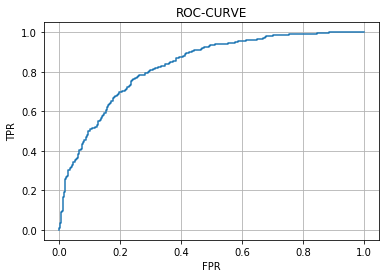

0.8317035165733987
0.8480698610562541


In [12]:
# Зададим сетку параметров для модели
param_grid_logreg = {'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 15, 20], 'class_weight':['balanced', None],'penalty':['l2'],  }
clf_log = LogisticRegression(solver='liblinear')
# Обучим модель на данных и классификатора выше
log_reg = learning_model(X_finish, Y_encoded, clf_log, param_grid_logreg, scoring = 'roc_auc')

В качестве метрики будем использовать площадь под AUC кривой (чтобы можно было сравнить разные алгоритмы между собой)

# Попробуем запустить случайный лес и градиентный бустинг

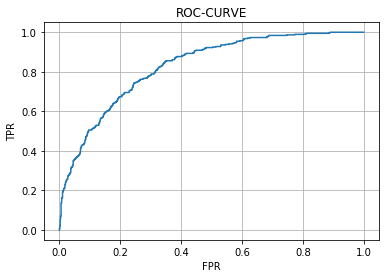

0.8281613182102904
0.8473199499545349


In [13]:
from sklearn import ensemble 
# Зададим classifier и сетку параметров
param_grid_rf = {'n_estimators': [1] + list(range(10, 55, 5)), 'min_samples_split': range(2, 25, 2)}
estimator_rf = ensemble.RandomForestClassifier(random_state=0)
# Обучим модель на данных и классификатора выше
rf_model = learning_model(X_finish, Y_encoded, estimator_rf, param_grid_rf, scoring = 'roc_auc')

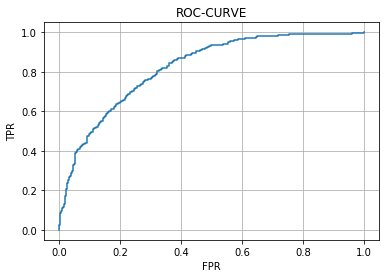

0.8213939980638916
0.8357889192402553


In [14]:
import xgboost as xgb

# Подбор параметров для градиентого бустинга - максимальная глубина дерева, количество деревьев, шаг градиента
param_grid_boosting = {"max_depth": [10,30,50],
              "min_child_weight" : [1,3,6],
              "n_estimators": [200],
              "learning_rate": [0.05, 0.1, 0.16],}
estimator_boosting = xgb.XGBClassifier()

# Обучим модель на данных и классификатора выше
boost_model = learning_model(X_finish, Y_encoded, estimator_boosting, param_grid_boosting, scoring = 'roc_auc')

## Экспортируем лучшую модель и энкодеры

In [16]:
import pickle
from joblib import dump, load

best_ensemble = log_reg
dump(best_ensemble, 'model.joblib')
dump(encoder, 'encoder.joblib') 
dump(scaler, 'scaler.joblib') 

['scaler.joblib']

## Предскажем для всех клиентов из датасета вероятность оттока и сохраним столбец в датасет

In [19]:
dataset['probability'] = best_ensemble.predict_proba(X_finish)

In [20]:
dataset.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,probability
0,7590-VHVEG,Female,No,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,0.353235
1,5575-GNVDE,Male,No,No,No,34,Yes,No,DSL,Yes,...,No,No,No,One year,No,Mailed check,56.95,1889.50,No,0.965905
2,3668-QPYBK,Male,No,No,No,2,Yes,No,DSL,Yes,...,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,0.706195
3,7795-CFOCW,Male,No,No,No,45,No,No phone service,DSL,Yes,...,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,0.977488
4,9237-HQITU,Female,No,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,0.318713
